<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/(Chee_Wee)TSSD_3_Simple_models_code_along_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Simple Models Code along

- Dense Model  
- Conv1D Model  
- LSTM Model  

### Imports

In [80]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, GlobalAveragePooling1D, LSTM

## Getting the data

M4 dataset

https://www.kaggle.com/yogesh94/m4-forecasting-competition-dataset

In [2]:
!wget -q https://www.dropbox.com/s/vtvrem02pby4hhp/m4_dataset.zip
!unzip -q m4_dataset.zip

replace Daily-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Daily-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Hourly-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Hourly-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Monthly-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Monthly-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Quarterly-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Quarterly-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Weekly-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Weekly-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Yearly-test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Yearly-train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace m4_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [4]:
ls

Daily-test.csv    m4_dataset.zip    Monthly-train.csv    Weekly-test.csv
Daily-train.csv   m4_dataset.zip.1  Quarterly-test.csv   Weekly-train.csv
Hourly-test.csv   m4_info.csv       Quarterly-train.csv  Yearly-test.csv
Hourly-train.csv  Monthly-test.csv  sample_data/         Yearly-train.csv


In [8]:
days = pd.read_csv('./Daily-train.csv')

In [9]:
days.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V9881,V9882,V9883,V9884,V9885,V9886,V9887,V9888,V9889,V9890,V9891,V9892,V9893,V9894,V9895,V9896,V9897,V9898,V9899,V9900,V9901,V9902,V9903,V9904,V9905,V9906,V9907,V9908,V9909,V9910,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,1021.50,1023.00,1023.30,1020.50,1021.40,1018.10,1022.60,1022.60,1021.00,1020.10,1017.00,1019.3,1017.30,1016.10,1017.80,1019.30,1025.10,1024.80,1025.10,1025.10,1022.60,1021.20,1017.20,1041.50,1041.70,1038.90,1041.00,1042.90,1042.10,1043.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,2781.40,2768.40,2779.00,2774.90,2770.00,2780.00,2752.30,2749.90,2748.40,2744.30,2757.30,2754.8,2752.50,2743.80,2763.70,2756.60,2756.30,2767.70,2771.70,2774.90,2770.20,2768.40,2759.20,2760.30,2746.00,2738.50,2713.60,2705.10,2701.80,2706.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,1066.10,1063.30,1060.50,1057.70,1054.90,1052.10,1049.30,1046.50,1043.70,1040.90,1038.10,1035.3,1032.50,1029.70,1025.50,1022.70,1019.90,1017.10,1014.30,1011.50,1008.70,1005.90,1003.10,1000.30,997.50,994.70,991.90,989.10,986.30,983.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,1064.00,1050.00,1036.00,1022.00,1092.00,1079.00,1064.00,1050.00,1036.00,1022.00,1092.00,1078.0,1064.00,1092.00,1078.00,1065.00,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1092.00,1078.00,1064.00,1050.00,1092.00,1078.00,1064.00,1050.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,3057.19,3063.93,3068.45,3072.98,3431.69,3436.86,3441.45,3446.05,3454.46,3459.42,3463.44,3467.3,3485.64,3475.19,3478.89,3482.34,3486.01,4087.11,4092.18,4096.39,4100.62,4106.51,4111.35,4115.66,4119.77,4139.93,4130.28,4135.06,4139.71,4145.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


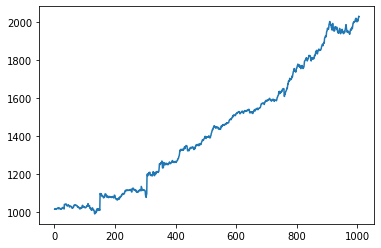

In [25]:
single_day = days.loc[0].transpose()
df = pd.DataFrame(single_day).reset_index().drop([0])

df[0].plot()

In [26]:
df = df.drop(['index'], axis =1)
df.columns = ['values']

#Take first 1000 data
df = df[:1000]

## Formating the data



In [27]:
#Convert to numpy
timesteps = np.array(df.index)
values = df['values'].to_numpy()

timesteps.shape, values.shape

((1000,), (1000,))

In [157]:
#make a train test split
split = int(len(values) * 0.8)

X_train, y_train = timesteps[:split], values[:split]
X_test, y_test = timesteps[split:], values[split:]

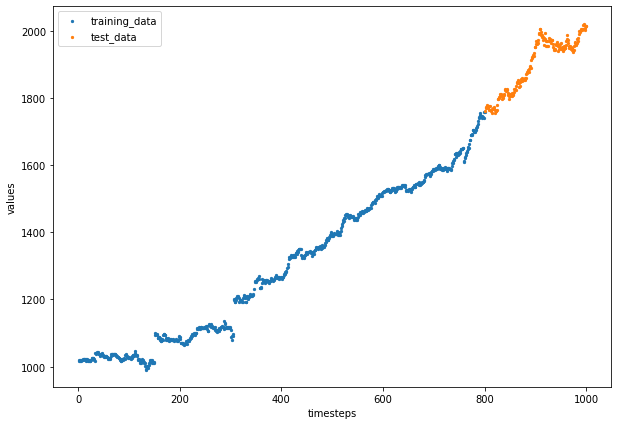

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Setting up a data loader


In [159]:
window_size = 10

def create_dataset(values, window_size):
  #dataset = tf.data.Dataset.from_tensor_slices(tf.constant(values, tf.float32))
  dataset = tf.expand_dims(tf.constant(values, tf.float32), axis=1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
  return dataset


In [160]:
train_dataset = create_dataset(y_train, window_size = 10)
test_dataset = create_dataset(y_test, window_size = 10)

In [161]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>)

## Model 1 Dense model

In [162]:
# Dense model

Inp = Input(shape=[window_size,1], name='Inp')
x = Flatten()(Inp)
x = Dense(128, activation='relu',name='Dense_01')(x)
x = Dense(128, activation='relu',name='Dense_02')(x)
outputs = Dense(1, name='Outputs')(x)

In [163]:
model_dense = tf.keras.Model(Inp, outputs, name='baseline_dense')

In [164]:
model_dense.summary()

Model: "baseline_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inp (InputLayer)             [(None, 10, 1)]           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10)                0         
_________________________________________________________________
Dense_01 (Dense)             (None, 128)               1408      
_________________________________________________________________
Dense_02 (Dense)             (None, 128)               16512     
_________________________________________________________________
Outputs (Dense)              (None, 1)                 129       
Total params: 18,049
Trainable params: 18,049
Non-trainable params: 0
_________________________________________________________________


In [165]:
model_dense.compile(loss='mae', optimizer='Adam', metrics=['mae'])

In [166]:
model_dense.fit(train_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 9ms/step - loss: 517.3267 - mae: 517.3267
Epoch 2/20
25/25 [==============================] - 0s 9ms/step - loss: 18.0744 - mae: 18.0744
Epoch 3/20
25/25 [==============================] - 0s 9ms/step - loss: 19.5542 - mae: 19.5542
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 23.8282 - mae: 23.8282
Epoch 5/20
25/25 [==============================] - 0s 8ms/step - loss: 13.4029 - mae: 13.4029
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 10.7096 - mae: 10.7096
Epoch 7/20
25/25 [==============================] - 0s 10ms/step - loss: 14.1642 - mae: 14.1642
Epoch 8/20
25/25 [==============================] - 0s 9ms/step - loss: 10.5683 - mae: 10.5683
Epoch 9/20
25/25 [==============================] - 0s 9ms/step - loss: 16.2968 - mae: 16.2968
Epoch 10/20
25/25 [==============================] - 0s 9ms/step - loss: 9.3083 - mae: 9.3083
Epoch 11/20
25/25 [=============================

In [167]:
model_dense.evaluate(test_dataset)

6/6 [==============================] - 0s 10ms/step - loss: 41.7257 - mae: 41.7257


[41.72565841674805, 41.72565841674805]

In [168]:
dense_preds = tf.squeeze(model_dense.predict(test_dataset))
dense_preds.shape

TensorShape([190])

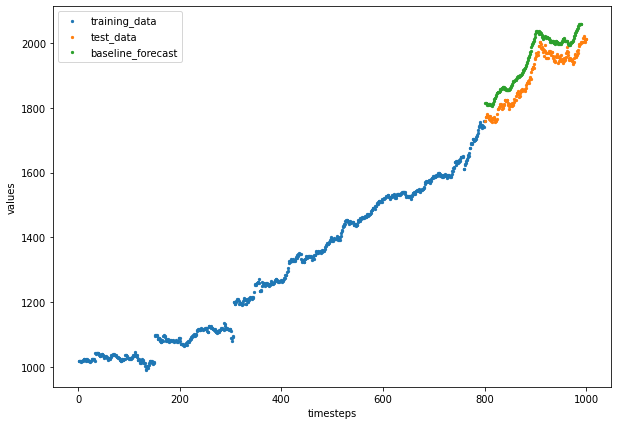

In [169]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], dense_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Model 2 - Conv1D

In [170]:
# conv1D model
Inp = Input(shape=[None,1],name='Input')
x = Conv1D(64, kernel_size=5, activation='relu', name='Conv1d')(Inp)
x= GlobalAveragePooling1D(name='GlobalPolling')(x)
outputs = Dense(1, name='Outputs')(x)

In [171]:
model_conv = tf.keras.Model(Inp, outputs, name='Baseline_conv')

In [172]:
model_conv.summary()

Model: "Baseline_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 1)]         0         
_________________________________________________________________
Conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
GlobalPolling (GlobalAverage (None, 64)                0         
_________________________________________________________________
Outputs (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [173]:
model_conv.compile(loss='mae', optimizer='Adam', metrics=['mae'])

In [174]:
#train the model
model_conv.fit(train_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 7ms/step - loss: 1030.1762 - mae: 1030.1762
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 218.2058 - mae: 218.2058
Epoch 3/20
25/25 [==============================] - 0s 8ms/step - loss: 25.8871 - mae: 25.8871
Epoch 4/20
25/25 [==============================] - 0s 9ms/step - loss: 9.8831 - mae: 9.8831
Epoch 5/20
25/25 [==============================] - 0s 9ms/step - loss: 11.5153 - mae: 11.5153
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 10.1421 - mae: 10.1421
Epoch 7/20
25/25 [==============================] - 0s 8ms/step - loss: 9.5190 - mae: 9.5190
Epoch 8/20
25/25 [==============================] - 0s 9ms/step - loss: 10.4445 - mae: 10.4445
Epoch 9/20
25/25 [==============================] - 0s 8ms/step - loss: 10.0848 - mae: 10.0848
Epoch 10/20
25/25 [==============================] - 0s 8ms/step - loss: 10.5767 - mae: 10.5767
Epoch 11/20
25/25 [============================

In [175]:
model_conv.evaluate(test_dataset)

6/6 [==============================] - 0s 14ms/step - loss: 14.0976 - mae: 14.0976


[14.097633361816406, 14.097633361816406]

In [176]:
# predict
conv_preds = tf.squeeze(model_conv.predict(test_dataset))
conv_preds.shape

TensorShape([190])

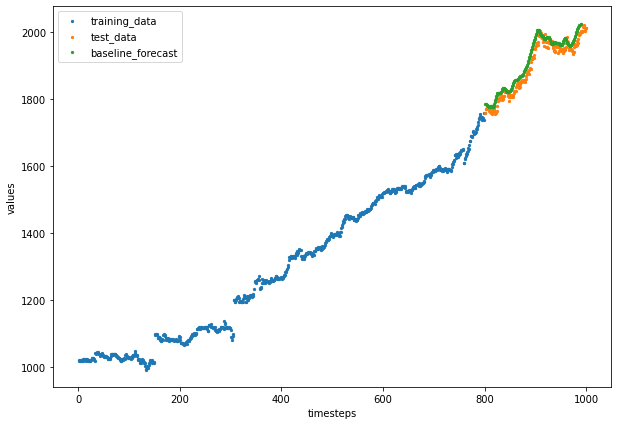

In [177]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], conv_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

## Model 3 LSTM

In [198]:
# LSTM model model
Inp = Input(shape=[None, 1], name='Inputs')
x = LSTM(64, return_sequences=True, activation='relu', name='LSTM_01')(Inp)
x = LSTM(64, return_sequences=False, activation='relu', name='LSTM_02')(x)
outputs = Dense(1, name='Output')(x)

In [199]:
model_lstm = tf.keras.Model(Inp, outputs, name='baseline_lstm')

In [200]:
model_lstm.compile(loss='mae', optimizer='adam',metrics=['mae','mape'])

In [201]:
model_lstm.summary()

Model: "baseline_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, None, 1)]         0         
_________________________________________________________________
LSTM_01 (LSTM)               (None, None, 64)          16896     
_________________________________________________________________
LSTM_02 (LSTM)               (None, 64)                33024     
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [202]:
# train the model
model_lstm.fit(train_dataset, epochs=20)

Epoch 1/20
25/25 [==============================] - 4s 50ms/step - loss: 773.4449 - mae: 773.4449 - mape: 67.8935
Epoch 2/20
25/25 [==============================] - 1s 52ms/step - loss: 146.5250 - mae: 146.5250 - mape: 14.0076
Epoch 3/20
25/25 [==============================] - 1s 53ms/step - loss: 28.2777 - mae: 28.2777 - mape: 2.5510
Epoch 4/20
25/25 [==============================] - 1s 49ms/step - loss: 19.7767 - mae: 19.7767 - mape: 1.7817
Epoch 5/20
25/25 [==============================] - 1s 53ms/step - loss: 19.2880 - mae: 19.2880 - mape: 1.7147
Epoch 6/20
25/25 [==============================] - 1s 50ms/step - loss: 14.3569 - mae: 14.3569 - mape: 1.2636
Epoch 7/20
25/25 [==============================] - 1s 52ms/step - loss: 17.4929 - mae: 17.4929 - mape: 1.5370
Epoch 8/20
25/25 [==============================] - 1s 50ms/step - loss: 21.1553 - mae: 21.1553 - mape: 1.8147
Epoch 9/20
25/25 [==============================] - 1s 48ms/step - loss: 13.1475 - mae: 13.1475 - mape: 1.

In [203]:
model_lstm.evaluate(test_dataset)

6/6 [==============================] - 0s 14ms/step - loss: 16.2664 - mae: 16.2664 - mape: 0.8511


[16.266353607177734, 16.266353607177734, 0.851051390171051]

In [204]:
lstm_preds = tf.squeeze(model_lstm.predict(test_dataset))
lstm_preds.shape

TensorShape([190])

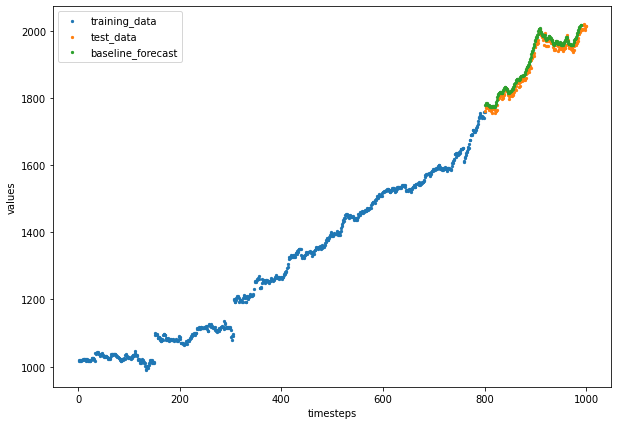

In [205]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train,s=5, label='training_data')
plt.scatter(X_test, y_test,s=5, label='test_data')
plt.scatter(X_test[:-10], lstm_preds,s=5, label='baseline_forecast') # we minus 10 becuase that is the window size

plt.legend()
plt.xlabel("timesteps")
plt.ylabel("values")
plt.show()

In [206]:
## Add in comparing on different Loss functions
def evaluate_metrics(y_true, y_preds, use_window=True, window_size=10):
  if use_window:
    y_true = y_true[window_size:]

  #convert to tf tensors
  y_true = tf.constant(y_true, tf.float32)
  y_preds = tf.constant(y_preds, tf.float32)

  #calculate loss metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)

  return {"mae": mae.numpy(), "mse": mse.numpy(), "mape": mape.numpy()}

In [207]:
evaluate_metrics(y_test, dense_preds)

{'mae': 41.72566, 'mape': 2.1933665, 'mse': 1914.8925}

In [208]:
evaluate_metrics(y_test, conv_preds)

{'mae': 14.097633, 'mape': 0.7404177, 'mse': 296.57663}

In [209]:
evaluate_metrics(y_test, lstm_preds)

{'mae': 16.266354, 'mape': 0.8510514, 'mse': 376.72305}